In [1]:
# Loading the drive helper and mounting
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [2]:
!ls "drive/Shared drives/Spring 2023/Machine Learning Capstone"

 Accident_binary_classification.ipynb
 Archive.zip
'Copy of traffic_accident_recognition.ipynb'
 new_traffic_accident_recognition.ipynb
 traffic_accident_recognition.ipynb
 traffic_detection_yolov8.ipynb
 trafficnet_dataset_v1


In [3]:
# importing all the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
import cv2
import random
import os
from os import listdir
from PIL import Image
from sklearn.preprocessing import label_binarize,  LabelBinarizer
from keras.preprocessing import image
from tensorflow.keras.utils import img_to_array, array_to_img
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dropout, Dense
from sklearn.model_selection import train_test_split
from keras.models import model_from_json
from keras.utils import to_categorical 

from tensorflow.keras.applications import ResNet50

<ipython-input-4-ed0d243cc4be>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(4,4,i)


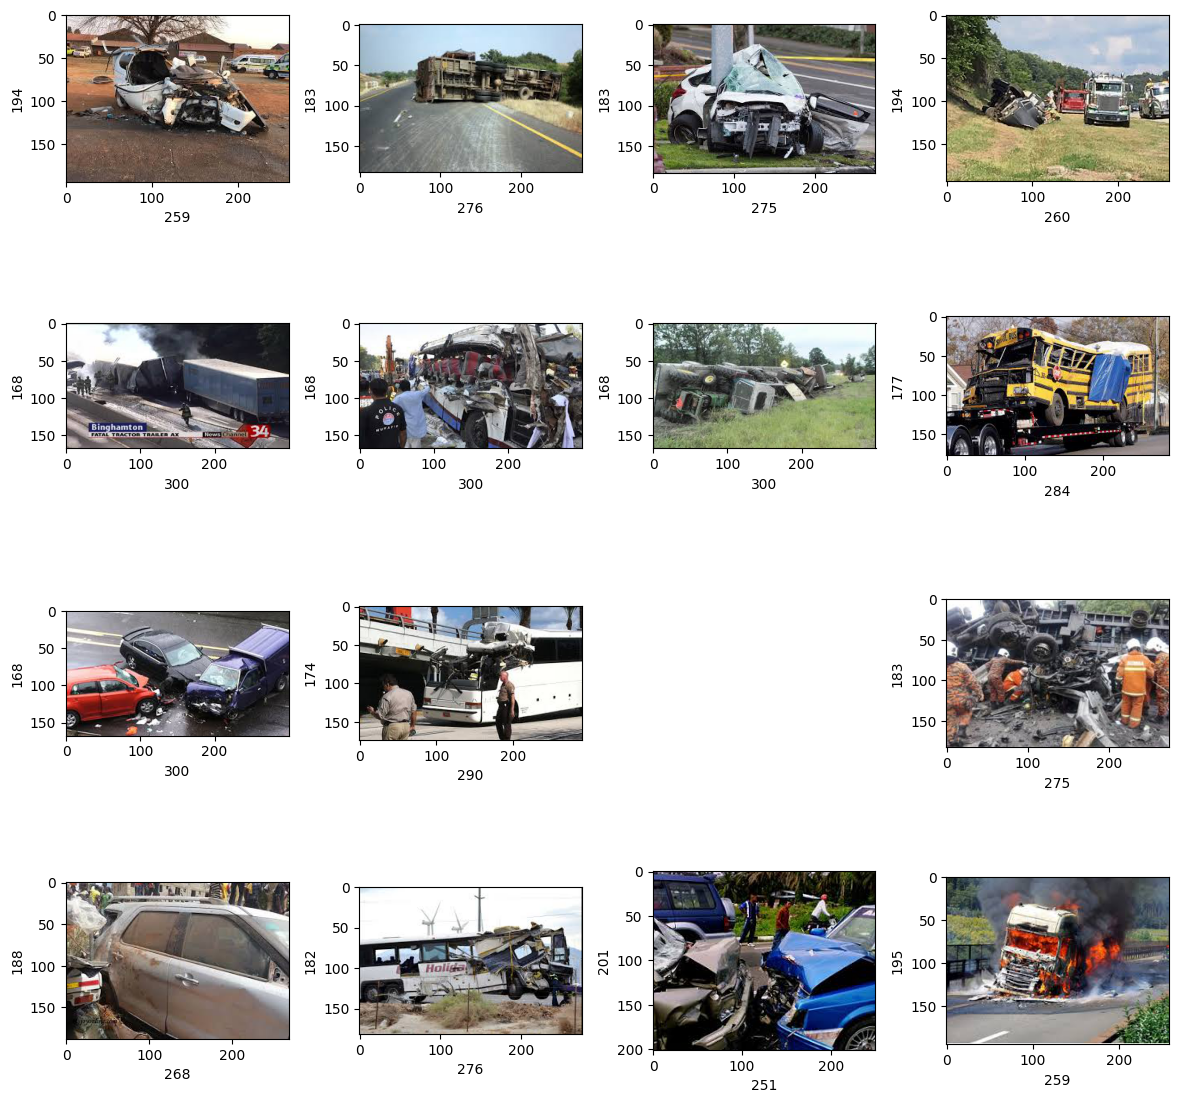

In [4]:
# visualizing the training/accident dataset to check variability of the dataset
plt.figure(figsize=(12,12))
path = "drive/Shared drives/Spring 2023/Machine Learning Capstone/trafficnet_dataset_v1/train/accident"
for i in range(1,17):
    plt.subplot(4,4,i)
    plt.tight_layout()
    rand_img = imread(path +'/'+ random.choice(sorted(os.listdir(path))))
    plt.imshow(rand_img)
    plt.xlabel(rand_img.shape[1], fontsize = 10)#width of image
    plt.ylabel(rand_img.shape[0], fontsize = 10)#height of image

In [5]:
# making a function to Convert images to numpy arrays
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            #resizing images as we found that they were not on one scale
            image = cv2.resize(image, (256,256))  
            #image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [6]:
# converting images into numpy arrays
train_dir = "drive/Shared drives/Spring 2023/Machine Learning Capstone/trafficnet_dataset_v1/train"
root_dir = listdir(train_dir)
image_list, label_list = [], []
all_labels = ['sparse-traffic', 'accident']
binary_labels = [0,1]
temp = -1

# Reading and converting image to numpy array
for directory in root_dir:
  # passing the images for fire class
  if directory == 'fire':
    continue
  if directory == 'dense_traffic':
    continue
  train_image_list = listdir(f"{train_dir}/{directory}")
  temp += 1
  for files in train_image_list:
    image_path = f"{train_dir}/{directory}/{files}"
    image_list.append(convert_image_to_array(image_path))
    label_list.append(binary_labels[temp])

In [7]:
len(label_list)

1800

In [8]:
label_counts = pd.DataFrame(label_list).value_counts()
label_counts.head()

0    900
1    900
dtype: int64

In [9]:
image_list[0].shape

(256, 256, 3)

In [10]:
len(label_list)

1800

In [11]:
# test train
x_train, x_test, y_train, y_test = train_test_split(image_list, label_list, test_size = 0.10, random_state = 10)

In [12]:
# normalizing and reshaping the training data, (value of pixel is from 0 to 255)
x_train = np.array(x_train, dtype=np.float16)/255.0
x_test = np.array(x_test, dtype=np.float16)/255.0
x_train = x_train.reshape(-1, 256, 256, 3)
x_test = x_test.reshape(-1, 256, 256, 3)

In [13]:
# converting the data into categorical that is one hot encoding (target variable y)
y_train = to_categorical(y_train)
y_test= to_categorical(y_test)

In [14]:
#using ResNet50 as base model
#base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

#making custom sequential model 
#using relu as the activation function to cater the problem of vanishing gradient problem
model = Sequential()
model.add(Conv2D(32, (3, 3), padding="same",input_shape=(256,256,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Conv2D(64, (3, 3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.2))
# here we have 2 param because we have 2 classes to be classified into
model.add(Dense(2, activation="sigmoid"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 85, 85, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 85, 85, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 42, 42, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 112896)            0         
                                                                 
 dense (Dense)               (None, 64)                7

In [15]:
# compiling the model
# using loss as categorical_crossentropy because we are doing multi-class classification
# using optimizer as Adam to counter local maxima problem
# using metrics as accuracy, precision, recall and F1-score, changed Adam from 0.0001
model.compile(loss = 'binary_crossentropy', optimizer = Adam(0.0001),metrics=['accuracy'])

In [16]:
# splitting into train and validation dataset
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.15)

In [17]:
epochs = 10
batch_size = 128
history = model.fit(x_train, y_train, batch_size = batch_size, epochs = epochs, validation_data = (x_val, y_val))

Epoch 1/10
11/11 [==============================] - 14s 432ms/step - loss: 0.6935 - accuracy: 0.5563 - val_loss: 0.6391 - val_accuracy: 0.7572
Epoch 2/10
11/11 [==============================] - 2s 181ms/step - loss: 0.6160 - accuracy: 0.7378 - val_loss: 0.5646 - val_accuracy: 0.7860
Epoch 3/10
11/11 [==============================] - 2s 184ms/step - loss: 0.5459 - accuracy: 0.7763 - val_loss: 0.4949 - val_accuracy: 0.8107
Epoch 4/10
11/11 [==============================] - 2s 159ms/step - loss: 0.4990 - accuracy: 0.7901 - val_loss: 0.4489 - val_accuracy: 0.8272
Epoch 5/10
11/11 [==============================] - 2s 156ms/step - loss: 0.4552 - accuracy: 0.8090 - val_loss: 0.4165 - val_accuracy: 0.8272
Epoch 6/10
11/11 [==============================] - 2s 165ms/step - loss: 0.4373 - accuracy: 0.8134 - val_loss: 0.4047 - val_accuracy: 0.8148
Epoch 7/10
11/11 [==============================] - 2s 154ms/step - loss: 0.4301 - accuracy: 0.8148 - val_loss: 0.3962 - val_accuracy: 0.8354
Epoch

In [18]:
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

6/6 [==============================] - 1s 48ms/step - loss: 0.3548 - accuracy: 0.8611
Test Accuracy: 86.11111044883728


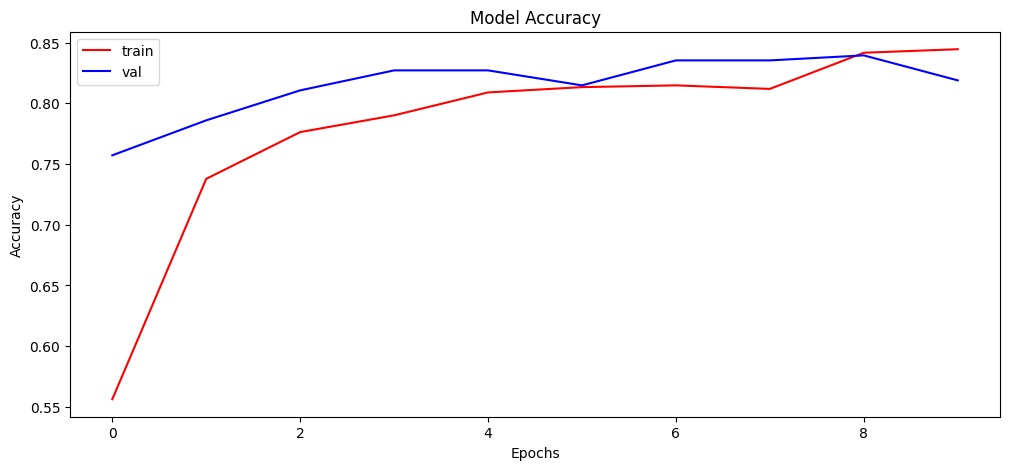

In [19]:
#Plot the training history
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], color='r')
plt.plot(history.history['val_accuracy'], color='b')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])

plt.show()

In [20]:
y_pred = model.predict(x_test)
y_pred=np.argmax(y_pred, axis=1)
y_test=np.argmax(y_test, axis=1)

6/6 [==============================] - 0s 24ms/step


In [21]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_test, y_pred)
print(cf_matrix)

[[86  9]
 [16 69]]


<Axes: >

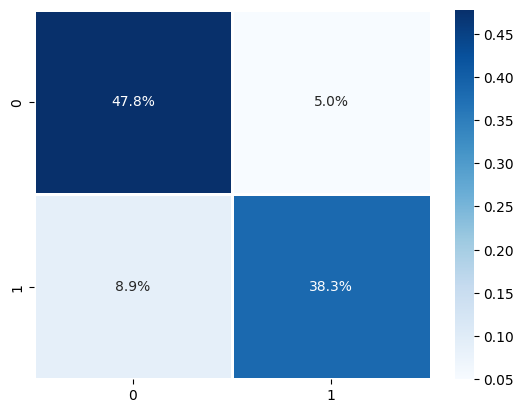

In [22]:
import seaborn as sns
labels = ['No-accident', 'Accident']
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, cmap='Blues',fmt='.1%', linewidths=1)

In [24]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=['No-accident', 'Accident']))

              precision    recall  f1-score   support

 No-accident       0.84      0.91      0.87        95
    Accident       0.88      0.81      0.85        85

    accuracy                           0.86       180
   macro avg       0.86      0.86      0.86       180
weighted avg       0.86      0.86      0.86       180

